<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[05:09:59] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


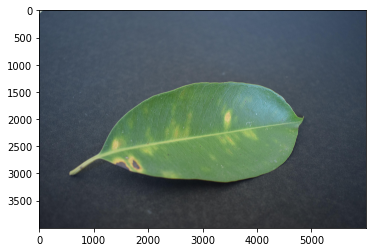

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

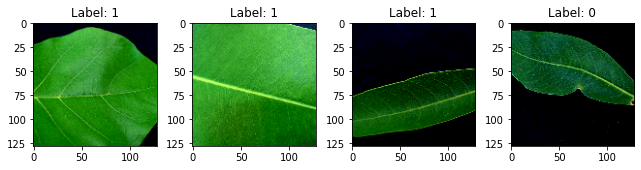

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[05:10:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[05:10:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2564057746742352 samples/sec                   batch loss = 1.3288648128509521 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.259672273188517 samples/sec                   batch loss = 0.8961710929870605 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2536947163766126 samples/sec                   batch loss = 0.6437767148017883 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2638510704365107 samples/sec                   batch loss = 0.9030948281288147 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2669764502642062 samples/sec                   batch loss = 1.4789685010910034 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2594202702722992 samples/sec                   batch loss = 0.21117331087589264 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2618155770883654 samples/sec                   batch loss = 1.2349975109100342 | accuracy = 0.5214285714285715


Epoch[1] Batch[40] Speed: 1.2646081389605321 samples/sec                   batch loss = 0.4328669607639313 | accuracy = 0.525


Epoch[1] Batch[45] Speed: 1.2726536371732964 samples/sec                   batch loss = 0.46518680453300476 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.2672279449131163 samples/sec                   batch loss = 0.6440625190734863 | accuracy = 0.555


Epoch[1] Batch[55] Speed: 1.2687790225588986 samples/sec                   batch loss = 0.4796774089336395 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2651388271589392 samples/sec                   batch loss = 0.3896405100822449 | accuracy = 0.5958333333333333


Epoch[1] Batch[65] Speed: 1.260748556530247 samples/sec                   batch loss = 0.7790672779083252 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2656912537688476 samples/sec                   batch loss = 1.0572274923324585 | accuracy = 0.5928571428571429


Epoch[1] Batch[75] Speed: 1.2669184713685548 samples/sec                   batch loss = 0.8129007816314697 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.2614997299506496 samples/sec                   batch loss = 0.7718571424484253 | accuracy = 0.61875


Epoch[1] Batch[85] Speed: 1.2611093379821217 samples/sec                   batch loss = 0.38452282547950745 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2637878557102333 samples/sec                   batch loss = 0.264943927526474 | accuracy = 0.6222222222222222


Epoch[1] Batch[95] Speed: 1.2633285964454666 samples/sec                   batch loss = 0.8065586090087891 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.2542436616356272 samples/sec                   batch loss = 0.5154057741165161 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.2689531985649827 samples/sec                   batch loss = 0.9483402967453003 | accuracy = 0.6238095238095238


Epoch[1] Batch[110] Speed: 1.2662049811320755 samples/sec                   batch loss = 0.5306010246276855 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.2607365245630424 samples/sec                   batch loss = 0.41857823729515076 | accuracy = 0.6195652173913043


Epoch[1] Batch[120] Speed: 1.2605742575522092 samples/sec                   batch loss = 0.4966401159763336 | accuracy = 0.6145833333333334


Epoch[1] Batch[125] Speed: 1.2612629246398903 samples/sec                   batch loss = 0.6623638868331909 | accuracy = 0.618


Epoch[1] Batch[130] Speed: 1.2623617802375093 samples/sec                   batch loss = 1.0073223114013672 | accuracy = 0.6192307692307693


Epoch[1] Batch[135] Speed: 1.2604641140862733 samples/sec                   batch loss = 0.6950166821479797 | accuracy = 0.6222222222222222


Epoch[1] Batch[140] Speed: 1.2612833108662853 samples/sec                   batch loss = 0.6997852921485901 | accuracy = 0.6285714285714286


Epoch[1] Batch[145] Speed: 1.266473855921261 samples/sec                   batch loss = 0.3404327630996704 | accuracy = 0.6310344827586207


Epoch[1] Batch[150] Speed: 1.2630388049880996 samples/sec                   batch loss = 0.9115414619445801 | accuracy = 0.625


Epoch[1] Batch[155] Speed: 1.2592864140530262 samples/sec                   batch loss = 1.3523892164230347 | accuracy = 0.6241935483870967


Epoch[1] Batch[160] Speed: 1.26355190358418 samples/sec                   batch loss = 0.8309751749038696 | accuracy = 0.61875


Epoch[1] Batch[165] Speed: 1.2606690740073927 samples/sec                   batch loss = 0.3892194628715515 | accuracy = 0.6212121212121212


Epoch[1] Batch[170] Speed: 1.2610710419513254 samples/sec                   batch loss = 0.6849396228790283 | accuracy = 0.625


Epoch[1] Batch[175] Speed: 1.2608809233284242 samples/sec                   batch loss = 1.1909033060073853 | accuracy = 0.6228571428571429


Epoch[1] Batch[180] Speed: 1.2596888247510614 samples/sec                   batch loss = 0.9541996717453003 | accuracy = 0.6208333333333333


Epoch[1] Batch[185] Speed: 1.262708089762585 samples/sec                   batch loss = 0.24307140707969666 | accuracy = 0.6243243243243243


Epoch[1] Batch[190] Speed: 1.2620120532371617 samples/sec                   batch loss = 0.7102288007736206 | accuracy = 0.6289473684210526


Epoch[1] Batch[195] Speed: 1.2660358578514417 samples/sec                   batch loss = 0.9867055416107178 | accuracy = 0.6294871794871795


Epoch[1] Batch[200] Speed: 1.26582628412149 samples/sec                   batch loss = 0.7109755277633667 | accuracy = 0.63


Epoch[1] Batch[205] Speed: 1.2627754735535228 samples/sec                   batch loss = 0.19881683588027954 | accuracy = 0.6365853658536585


Epoch[1] Batch[210] Speed: 1.2758729202215915 samples/sec                   batch loss = 0.9296013712882996 | accuracy = 0.6345238095238095


Epoch[1] Batch[215] Speed: 1.274118071716196 samples/sec                   batch loss = 0.5802537202835083 | accuracy = 0.6360465116279069


Epoch[1] Batch[220] Speed: 1.2752727963194292 samples/sec                   batch loss = 0.3925788998603821 | accuracy = 0.6397727272727273


Epoch[1] Batch[225] Speed: 1.2623822020020279 samples/sec                   batch loss = 0.3187743127346039 | accuracy = 0.6433333333333333


Epoch[1] Batch[230] Speed: 1.270321012960636 samples/sec                   batch loss = 0.5072669982910156 | accuracy = 0.6434782608695652


Epoch[1] Batch[235] Speed: 1.2743663115268622 samples/sec                   batch loss = 0.29012781381607056 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.2691289584690706 samples/sec                   batch loss = 0.5419418215751648 | accuracy = 0.646875


Epoch[1] Batch[245] Speed: 1.2659449130525788 samples/sec                   batch loss = 0.4772293269634247 | accuracy = 0.6438775510204081


Epoch[1] Batch[250] Speed: 1.2738657695179243 samples/sec                   batch loss = 0.4678715169429779 | accuracy = 0.644


Epoch[1] Batch[255] Speed: 1.2734407193538106 samples/sec                   batch loss = 1.118438959121704 | accuracy = 0.6431372549019608


Epoch[1] Batch[260] Speed: 1.2654463818406823 samples/sec                   batch loss = 0.2692011892795563 | accuracy = 0.6471153846153846


Epoch[1] Batch[265] Speed: 1.2757644526731473 samples/sec                   batch loss = 0.5308219790458679 | accuracy = 0.6462264150943396


Epoch[1] Batch[270] Speed: 1.2696033980164112 samples/sec                   batch loss = 0.3572154939174652 | accuracy = 0.6444444444444445


Epoch[1] Batch[275] Speed: 1.276823138717662 samples/sec                   batch loss = 0.7397791147232056 | accuracy = 0.6454545454545455


Epoch[1] Batch[280] Speed: 1.268390633580824 samples/sec                   batch loss = 0.6330336928367615 | accuracy = 0.6464285714285715


Epoch[1] Batch[285] Speed: 1.2728684715972736 samples/sec                   batch loss = 1.6894159317016602 | accuracy = 0.6464912280701754


Epoch[1] Batch[290] Speed: 1.274533020365069 samples/sec                   batch loss = 0.426067590713501 | accuracy = 0.65


Epoch[1] Batch[295] Speed: 1.26854926016486 samples/sec                   batch loss = 0.9391365647315979 | accuracy = 0.6508474576271186


Epoch[1] Batch[300] Speed: 1.2671080227214007 samples/sec                   batch loss = 0.3925330638885498 | accuracy = 0.6533333333333333


Epoch[1] Batch[305] Speed: 1.2742689396672529 samples/sec                   batch loss = 0.8099550604820251 | accuracy = 0.6557377049180327


Epoch[1] Batch[310] Speed: 1.270012526611859 samples/sec                   batch loss = 0.6618126630783081 | accuracy = 0.6564516129032258


Epoch[1] Batch[315] Speed: 1.264446017434464 samples/sec                   batch loss = 0.4632842540740967 | accuracy = 0.6555555555555556


Epoch[1] Batch[320] Speed: 1.2688169245610814 samples/sec                   batch loss = 0.3450169563293457 | accuracy = 0.65625


Epoch[1] Batch[325] Speed: 1.2759680142810446 samples/sec                   batch loss = 0.7392614483833313 | accuracy = 0.6569230769230769


Epoch[1] Batch[330] Speed: 1.2695245242768374 samples/sec                   batch loss = 0.5510575771331787 | accuracy = 0.6583333333333333


Epoch[1] Batch[335] Speed: 1.272762638475733 samples/sec                   batch loss = 0.5311816930770874 | accuracy = 0.6582089552238806


Epoch[1] Batch[340] Speed: 1.2695305763603693 samples/sec                   batch loss = 0.45023173093795776 | accuracy = 0.6602941176470588


Epoch[1] Batch[345] Speed: 1.275972672313415 samples/sec                   batch loss = 0.7183537483215332 | accuracy = 0.658695652173913


Epoch[1] Batch[350] Speed: 1.2691830113072864 samples/sec                   batch loss = 0.7204068899154663 | accuracy = 0.6592857142857143


Epoch[1] Batch[355] Speed: 1.2698193181709811 samples/sec                   batch loss = 0.30205750465393066 | accuracy = 0.6619718309859155


Epoch[1] Batch[360] Speed: 1.2715382443721497 samples/sec                   batch loss = 0.5200034379959106 | accuracy = 0.6604166666666667


Epoch[1] Batch[365] Speed: 1.2698472864998813 samples/sec                   batch loss = 0.46012693643569946 | accuracy = 0.663013698630137


Epoch[1] Batch[370] Speed: 1.2703841134139993 samples/sec                   batch loss = 0.16852355003356934 | accuracy = 0.6648648648648648


Epoch[1] Batch[375] Speed: 1.26857122549722 samples/sec                   batch loss = 0.44152334332466125 | accuracy = 0.666


Epoch[1] Batch[380] Speed: 1.2710785360654895 samples/sec                   batch loss = 0.5799714922904968 | accuracy = 0.6677631578947368


Epoch[1] Batch[385] Speed: 1.2664299755594315 samples/sec                   batch loss = 0.7355523109436035 | accuracy = 0.6694805194805195


Epoch[1] Batch[390] Speed: 1.2689189353743073 samples/sec                   batch loss = 0.6511151790618896 | accuracy = 0.6692307692307692


Epoch[1] Batch[395] Speed: 1.2728925182545854 samples/sec                   batch loss = 1.0275099277496338 | accuracy = 0.670253164556962


Epoch[1] Batch[400] Speed: 1.2674247698615302 samples/sec                   batch loss = 0.5025439262390137 | accuracy = 0.666875


Epoch[1] Batch[405] Speed: 1.2673351571484428 samples/sec                   batch loss = 0.44019585847854614 | accuracy = 0.6679012345679012


Epoch[1] Batch[410] Speed: 1.2708865434944467 samples/sec                   batch loss = 0.9103964567184448 | accuracy = 0.6682926829268293


Epoch[1] Batch[415] Speed: 1.269568523278579 samples/sec                   batch loss = 0.8763138651847839 | accuracy = 0.6680722891566265


Epoch[1] Batch[420] Speed: 1.2743587612878842 samples/sec                   batch loss = 0.710094690322876 | accuracy = 0.6702380952380952


Epoch[1] Batch[425] Speed: 1.2722521636994435 samples/sec                   batch loss = 0.48577624559402466 | accuracy = 0.6705882352941176


Epoch[1] Batch[430] Speed: 1.2717611857752573 samples/sec                   batch loss = 0.7931261658668518 | accuracy = 0.6691860465116279


Epoch[1] Batch[435] Speed: 1.26587060021881 samples/sec                   batch loss = 0.6588691473007202 | accuracy = 0.6689655172413793


Epoch[1] Batch[440] Speed: 1.2624877408126547 samples/sec                   batch loss = 0.842071533203125 | accuracy = 0.6681818181818182


Epoch[1] Batch[445] Speed: 1.263203609356245 samples/sec                   batch loss = 0.5174059271812439 | accuracy = 0.6674157303370787


Epoch[1] Batch[450] Speed: 1.268710708719735 samples/sec                   batch loss = 1.0344583988189697 | accuracy = 0.6666666666666666


Epoch[1] Batch[455] Speed: 1.260588464903729 samples/sec                   batch loss = 0.5687253475189209 | accuracy = 0.6664835164835164


Epoch[1] Batch[460] Speed: 1.2635296359293586 samples/sec                   batch loss = 0.44498640298843384 | accuracy = 0.6657608695652174


Epoch[1] Batch[465] Speed: 1.2627385969067706 samples/sec                   batch loss = 0.7560373544692993 | accuracy = 0.6666666666666666


Epoch[1] Batch[470] Speed: 1.2651474133773157 samples/sec                   batch loss = 0.6046057343482971 | accuracy = 0.6659574468085107


Epoch[1] Batch[475] Speed: 1.2615871911559342 samples/sec                   batch loss = 0.3345165252685547 | accuracy = 0.6678947368421052


Epoch[1] Batch[480] Speed: 1.2672490987480025 samples/sec                   batch loss = 0.48017406463623047 | accuracy = 0.6671875


Epoch[1] Batch[485] Speed: 1.2692598261022188 samples/sec                   batch loss = 0.8162022233009338 | accuracy = 0.6664948453608247


Epoch[1] Batch[490] Speed: 1.2716064775377554 samples/sec                   batch loss = 0.48072388768196106 | accuracy = 0.6673469387755102


Epoch[1] Batch[495] Speed: 1.266677810449093 samples/sec                   batch loss = 0.8552886843681335 | accuracy = 0.6661616161616162


Epoch[1] Batch[500] Speed: 1.273256612584504 samples/sec                   batch loss = 1.0756938457489014 | accuracy = 0.666


Epoch[1] Batch[505] Speed: 1.2705126422596886 samples/sec                   batch loss = 0.8003421425819397 | accuracy = 0.6673267326732674


Epoch[1] Batch[510] Speed: 1.2630455560822047 samples/sec                   batch loss = 0.3089742362499237 | accuracy = 0.6686274509803921


Epoch[1] Batch[515] Speed: 1.2692320756848088 samples/sec                   batch loss = 0.1890263557434082 | accuracy = 0.6694174757281554


Epoch[1] Batch[520] Speed: 1.266769147527514 samples/sec                   batch loss = 0.2815314531326294 | accuracy = 0.6706730769230769


Epoch[1] Batch[525] Speed: 1.2697751095797951 samples/sec                   batch loss = 0.45071783661842346 | accuracy = 0.67


Epoch[1] Batch[530] Speed: 1.26336817133332 samples/sec                   batch loss = 0.6946026682853699 | accuracy = 0.6712264150943397


Epoch[1] Batch[535] Speed: 1.2702567646718559 samples/sec                   batch loss = 0.9481183886528015 | accuracy = 0.6691588785046729


Epoch[1] Batch[540] Speed: 1.2689126012055763 samples/sec                   batch loss = 0.45043128728866577 | accuracy = 0.6694444444444444


Epoch[1] Batch[545] Speed: 1.2664690757778396 samples/sec                   batch loss = 0.32294780015945435 | accuracy = 0.6701834862385321


Epoch[1] Batch[550] Speed: 1.2646981291045907 samples/sec                   batch loss = 0.7743834853172302 | accuracy = 0.6713636363636364


Epoch[1] Batch[555] Speed: 1.2762791096787907 samples/sec                   batch loss = 0.6154270768165588 | accuracy = 0.6738738738738739


Epoch[1] Batch[560] Speed: 1.26808902645848 samples/sec                   batch loss = 0.47757601737976074 | accuracy = 0.6745535714285714


Epoch[1] Batch[565] Speed: 1.2670036237181355 samples/sec                   batch loss = 0.21386323869228363 | accuracy = 0.6756637168141593


Epoch[1] Batch[570] Speed: 1.2629664492016548 samples/sec                   batch loss = 2.273479700088501 | accuracy = 0.675


Epoch[1] Batch[575] Speed: 1.2758391555372166 samples/sec                   batch loss = 0.4622926414012909 | accuracy = 0.6752173913043479


Epoch[1] Batch[580] Speed: 1.2711765767080443 samples/sec                   batch loss = 0.6773919463157654 | accuracy = 0.6741379310344827


Epoch[1] Batch[585] Speed: 1.2643498697495998 samples/sec                   batch loss = 0.3433269262313843 | accuracy = 0.6756410256410257


Epoch[1] Batch[590] Speed: 1.264912097770558 samples/sec                   batch loss = 0.5784657597541809 | accuracy = 0.6754237288135593


Epoch[1] Batch[595] Speed: 1.2642684081801943 samples/sec                   batch loss = 0.7378271222114563 | accuracy = 0.6764705882352942


Epoch[1] Batch[600] Speed: 1.2627641632189541 samples/sec                   batch loss = 0.38703006505966187 | accuracy = 0.6770833333333334


Epoch[1] Batch[605] Speed: 1.2671833423088166 samples/sec                   batch loss = 1.074277400970459 | accuracy = 0.6764462809917355


Epoch[1] Batch[610] Speed: 1.2622559775819844 samples/sec                   batch loss = 0.40431368350982666 | accuracy = 0.6770491803278689


Epoch[1] Batch[615] Speed: 1.265229751588455 samples/sec                   batch loss = 0.26712819933891296 | accuracy = 0.6788617886178862


Epoch[1] Batch[620] Speed: 1.2629233819534134 samples/sec                   batch loss = 0.5483771562576294 | accuracy = 0.6798387096774193


Epoch[1] Batch[625] Speed: 1.2670899358691723 samples/sec                   batch loss = 0.5467216968536377 | accuracy = 0.6808


Epoch[1] Batch[630] Speed: 1.2743145264289066 samples/sec                   batch loss = 0.38733214139938354 | accuracy = 0.680952380952381


Epoch[1] Batch[635] Speed: 1.2670020927883383 samples/sec                   batch loss = 0.4120587110519409 | accuracy = 0.6807086614173228


Epoch[1] Batch[640] Speed: 1.2645665800392805 samples/sec                   batch loss = 0.3841123580932617 | accuracy = 0.680859375


Epoch[1] Batch[645] Speed: 1.2630959538536617 samples/sec                   batch loss = 0.9079666137695312 | accuracy = 0.6806201550387597


Epoch[1] Batch[650] Speed: 1.2639329543316022 samples/sec                   batch loss = 2.039106845855713 | accuracy = 0.6807692307692308


Epoch[1] Batch[655] Speed: 1.2596114617536371 samples/sec                   batch loss = 0.8374689817428589 | accuracy = 0.6812977099236641


Epoch[1] Batch[660] Speed: 1.267519566330605 samples/sec                   batch loss = 0.506545901298523 | accuracy = 0.6821969696969697


Epoch[1] Batch[665] Speed: 1.269988684778893 samples/sec                   batch loss = 1.1762267351150513 | accuracy = 0.6819548872180451


Epoch[1] Batch[670] Speed: 1.263875444068299 samples/sec                   batch loss = 0.18788377940654755 | accuracy = 0.682089552238806


Epoch[1] Batch[675] Speed: 1.265344546840224 samples/sec                   batch loss = 0.29065194725990295 | accuracy = 0.6822222222222222


Epoch[1] Batch[680] Speed: 1.2624177279482307 samples/sec                   batch loss = 1.1498774290084839 | accuracy = 0.6827205882352941


Epoch[1] Batch[685] Speed: 1.268796102168194 samples/sec                   batch loss = 0.287727952003479 | accuracy = 0.6835766423357664


Epoch[1] Batch[690] Speed: 1.2623987298673058 samples/sec                   batch loss = 0.20782676339149475 | accuracy = 0.6844202898550724


Epoch[1] Batch[695] Speed: 1.267855681385629 samples/sec                   batch loss = 0.272990345954895 | accuracy = 0.6848920863309352


Epoch[1] Batch[700] Speed: 1.2729223605505218 samples/sec                   batch loss = 0.22273771464824677 | accuracy = 0.6853571428571429


Epoch[1] Batch[705] Speed: 1.2675451350790432 samples/sec                   batch loss = 0.5942202210426331 | accuracy = 0.6843971631205674


Epoch[1] Batch[710] Speed: 1.2719469817898688 samples/sec                   batch loss = 0.42038410902023315 | accuracy = 0.6834507042253521


Epoch[1] Batch[715] Speed: 1.2671637219858798 samples/sec                   batch loss = 0.9891642332077026 | accuracy = 0.6832167832167833


Epoch[1] Batch[720] Speed: 1.2720121727048368 samples/sec                   batch loss = 1.6111677885055542 | accuracy = 0.6829861111111111


Epoch[1] Batch[725] Speed: 1.2696219410125666 samples/sec                   batch loss = 0.7968543171882629 | accuracy = 0.6834482758620689


Epoch[1] Batch[730] Speed: 1.2624828957103376 samples/sec                   batch loss = 0.5689471960067749 | accuracy = 0.684931506849315


Epoch[1] Batch[735] Speed: 1.2722603643484733 samples/sec                   batch loss = 0.6265479922294617 | accuracy = 0.6843537414965987


Epoch[1] Batch[740] Speed: 1.2745266300238964 samples/sec                   batch loss = 0.6506620049476624 | accuracy = 0.6844594594594594


Epoch[1] Batch[745] Speed: 1.2619999022126274 samples/sec                   batch loss = 0.5336688160896301 | accuracy = 0.6855704697986578


Epoch[1] Batch[750] Speed: 1.2652812780526337 samples/sec                   batch loss = 0.3433266282081604 | accuracy = 0.685


Epoch[1] Batch[755] Speed: 1.270706735461835 samples/sec                   batch loss = 0.5524353981018066 | accuracy = 0.6834437086092715


Epoch[1] Batch[760] Speed: 1.2701611737086003 samples/sec                   batch loss = 0.5387395620346069 | accuracy = 0.6832236842105263


Epoch[1] Batch[765] Speed: 1.2618284837886047 samples/sec                   batch loss = 0.7546927332878113 | accuracy = 0.6833333333333333


Epoch[1] Batch[770] Speed: 1.2633225082212418 samples/sec                   batch loss = 0.6286312937736511 | accuracy = 0.6837662337662338


Epoch[1] Batch[775] Speed: 1.2682273491063598 samples/sec                   batch loss = 0.254415899515152 | accuracy = 0.6851612903225807


Epoch[1] Batch[780] Speed: 1.2639621875478162 samples/sec                   batch loss = 0.42339837551116943 | accuracy = 0.6862179487179487


Epoch[1] Batch[785] Speed: 1.2733954850411542 samples/sec                   batch loss = 1.1578936576843262 | accuracy = 0.6863057324840764


[Epoch 1] training: accuracy=0.6865482233502538
[Epoch 1] time cost: 648.3818480968475
[Epoch 1] validation: validation accuracy=0.7855555555555556


Epoch[2] Batch[5] Speed: 1.2631705118948218 samples/sec                   batch loss = 0.6868851184844971 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2634229714253353 samples/sec                   batch loss = 0.24113348126411438 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2651548548608482 samples/sec                   batch loss = 0.420112282037735 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.268436855611451 samples/sec                   batch loss = 0.6503739356994629 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2657040489032114 samples/sec                   batch loss = 0.28879275918006897 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2646834476348117 samples/sec                   batch loss = 0.18728399276733398 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2634660727541345 samples/sec                   batch loss = 0.5831254720687866 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.2642881294918218 samples/sec                   batch loss = 1.831154704093933 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2683134445466437 samples/sec                   batch loss = 0.37587279081344604 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2635529503735932 samples/sec                   batch loss = 0.7943605780601501 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.2711980552140043 samples/sec                   batch loss = 0.2997969388961792 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.26270400324775 samples/sec                   batch loss = 0.2587801516056061 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2608539171078696 samples/sec                   batch loss = 0.5102102160453796 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2668664288267641 samples/sec                   batch loss = 0.480142742395401 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2670452472896554 samples/sec                   batch loss = 0.19737914204597473 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2638087044466555 samples/sec                   batch loss = 0.8284707069396973 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2644530694755145 samples/sec                   batch loss = 0.47912731766700745 | accuracy = 0.7323529411764705


Epoch[2] Batch[90] Speed: 1.266822138634331 samples/sec                   batch loss = 0.6745129823684692 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.2637284548634728 samples/sec                   batch loss = 0.5512178540229797 | accuracy = 0.7210526315789474


Epoch[2] Batch[100] Speed: 1.2581278006518903 samples/sec                   batch loss = 0.19977004826068878 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2673785258213812 samples/sec                   batch loss = 0.2805447578430176 | accuracy = 0.7309523809523809


Epoch[2] Batch[110] Speed: 1.2646817316411123 samples/sec                   batch loss = 0.4941079914569855 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.26429584669429 samples/sec                   batch loss = 0.5143468976020813 | accuracy = 0.7260869565217392


Epoch[2] Batch[120] Speed: 1.2661188850478922 samples/sec                   batch loss = 0.31594130396842957 | accuracy = 0.7208333333333333


Epoch[2] Batch[125] Speed: 1.268961836636182 samples/sec                   batch loss = 0.4589822292327881 | accuracy = 0.716


Epoch[2] Batch[130] Speed: 1.2712047011767869 samples/sec                   batch loss = 0.1987246423959732 | accuracy = 0.7173076923076923


Epoch[2] Batch[135] Speed: 1.2637732905628 samples/sec                   batch loss = 0.5490028262138367 | accuracy = 0.7166666666666667


Epoch[2] Batch[140] Speed: 1.2701498268433402 samples/sec                   batch loss = 0.4096691906452179 | accuracy = 0.7142857142857143


Epoch[2] Batch[145] Speed: 1.2711936246107556 samples/sec                   batch loss = 0.28532883524894714 | accuracy = 0.7155172413793104


Epoch[2] Batch[150] Speed: 1.26096346529975 samples/sec                   batch loss = 0.5324326753616333 | accuracy = 0.7183333333333334


Epoch[2] Batch[155] Speed: 1.2667131003870609 samples/sec                   batch loss = 0.1906464844942093 | accuracy = 0.7193548387096774


Epoch[2] Batch[160] Speed: 1.2687911125718663 samples/sec                   batch loss = 0.4407027065753937 | accuracy = 0.715625


Epoch[2] Batch[165] Speed: 1.264115041200563 samples/sec                   batch loss = 0.3761937618255615 | accuracy = 0.7196969696969697


Epoch[2] Batch[170] Speed: 1.2624946760238214 samples/sec                   batch loss = 0.32786884903907776 | accuracy = 0.7235294117647059


Epoch[2] Batch[175] Speed: 1.2675652460553706 samples/sec                   batch loss = 0.4020099937915802 | accuracy = 0.7285714285714285


Epoch[2] Batch[180] Speed: 1.2656207896792695 samples/sec                   batch loss = 0.5155340433120728 | accuracy = 0.7319444444444444


Epoch[2] Batch[185] Speed: 1.2620085408075894 samples/sec                   batch loss = 0.7593591213226318 | accuracy = 0.731081081081081


Epoch[2] Batch[190] Speed: 1.2659475877131094 samples/sec                   batch loss = 0.48029378056526184 | accuracy = 0.7315789473684211


Epoch[2] Batch[195] Speed: 1.2651095394908243 samples/sec                   batch loss = 0.6819535493850708 | accuracy = 0.7294871794871794


Epoch[2] Batch[200] Speed: 1.2699653244962992 samples/sec                   batch loss = 0.30737537145614624 | accuracy = 0.7325


Epoch[2] Batch[205] Speed: 1.2635130784383972 samples/sec                   batch loss = 0.5250890254974365 | accuracy = 0.7353658536585366


Epoch[2] Batch[210] Speed: 1.2688822748496582 samples/sec                   batch loss = 0.43276694416999817 | accuracy = 0.736904761904762


Epoch[2] Batch[215] Speed: 1.2654970668483412 samples/sec                   batch loss = 0.70381760597229 | accuracy = 0.7313953488372092


Epoch[2] Batch[220] Speed: 1.2665887814307506 samples/sec                   batch loss = 0.23273718357086182 | accuracy = 0.7352272727272727


Epoch[2] Batch[225] Speed: 1.2620529697355665 samples/sec                   batch loss = 1.0563288927078247 | accuracy = 0.7355555555555555


Epoch[2] Batch[230] Speed: 1.2651859573934112 samples/sec                   batch loss = 0.66547691822052 | accuracy = 0.7369565217391304


Epoch[2] Batch[235] Speed: 1.2707672754182373 samples/sec                   batch loss = 0.6061853170394897 | accuracy = 0.7351063829787234


Epoch[2] Batch[240] Speed: 1.2609198711784424 samples/sec                   batch loss = 0.24261212348937988 | accuracy = 0.7385416666666667


Epoch[2] Batch[245] Speed: 1.2684112508753906 samples/sec                   batch loss = 1.084987759590149 | accuracy = 0.7377551020408163


Epoch[2] Batch[250] Speed: 1.268770099125689 samples/sec                   batch loss = 0.28972816467285156 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2647756414750606 samples/sec                   batch loss = 1.4257197380065918 | accuracy = 0.7392156862745098


Epoch[2] Batch[260] Speed: 1.265639025567812 samples/sec                   batch loss = 0.23018015921115875 | accuracy = 0.7432692307692308


Epoch[2] Batch[265] Speed: 1.2706101144776423 samples/sec                   batch loss = 0.29283440113067627 | accuracy = 0.7424528301886792


Epoch[2] Batch[270] Speed: 1.2653471235312694 samples/sec                   batch loss = 0.3112853765487671 | accuracy = 0.7425925925925926


Epoch[2] Batch[275] Speed: 1.272572067368614 samples/sec                   batch loss = 1.0600848197937012 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.265727443661067 samples/sec                   batch loss = 0.462820440530777 | accuracy = 0.7419642857142857


Epoch[2] Batch[285] Speed: 1.266185582213344 samples/sec                   batch loss = 0.5293006300926208 | accuracy = 0.7412280701754386


Epoch[2] Batch[290] Speed: 1.266836008879895 samples/sec                   batch loss = 0.6232444643974304 | accuracy = 0.7439655172413793


Epoch[2] Batch[295] Speed: 1.2642901302389709 samples/sec                   batch loss = 0.6024305820465088 | accuracy = 0.7440677966101695


Epoch[2] Batch[300] Speed: 1.2663251147674914 samples/sec                   batch loss = 0.5897470116615295 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2651161219430462 samples/sec                   batch loss = 0.468667596578598 | accuracy = 0.7426229508196721


Epoch[2] Batch[310] Speed: 1.2645254050864818 samples/sec                   batch loss = 0.514050304889679 | accuracy = 0.7419354838709677


Epoch[2] Batch[315] Speed: 1.2578924480939542 samples/sec                   batch loss = 0.44580844044685364 | accuracy = 0.7420634920634921


Epoch[2] Batch[320] Speed: 1.2631734601615339 samples/sec                   batch loss = 0.4311777949333191 | accuracy = 0.740625


Epoch[2] Batch[325] Speed: 1.2705655621413445 samples/sec                   batch loss = 0.36097824573516846 | accuracy = 0.7415384615384616


Epoch[2] Batch[330] Speed: 1.26582026730442 samples/sec                   batch loss = 0.11390893906354904 | accuracy = 0.7424242424242424


Epoch[2] Batch[335] Speed: 1.2669954906959686 samples/sec                   batch loss = 0.27755793929100037 | accuracy = 0.7440298507462687


Epoch[2] Batch[340] Speed: 1.2669150272447034 samples/sec                   batch loss = 0.9974335432052612 | accuracy = 0.7433823529411765


Epoch[2] Batch[345] Speed: 1.2662482724881086 samples/sec                   batch loss = 0.36366888880729675 | accuracy = 0.7427536231884058


Epoch[2] Batch[350] Speed: 1.259511036438791 samples/sec                   batch loss = 0.3420644998550415 | accuracy = 0.7421428571428571


Epoch[2] Batch[355] Speed: 1.2574465103067014 samples/sec                   batch loss = 0.42908337712287903 | accuracy = 0.7436619718309859


Epoch[2] Batch[360] Speed: 1.258551374032797 samples/sec                   batch loss = 0.3988310992717743 | accuracy = 0.7458333333333333


Epoch[2] Batch[365] Speed: 1.2576762277665279 samples/sec                   batch loss = 0.4166419804096222 | accuracy = 0.7431506849315068


Epoch[2] Batch[370] Speed: 1.263649357597318 samples/sec                   batch loss = 0.2643011510372162 | accuracy = 0.745945945945946


Epoch[2] Batch[375] Speed: 1.2644481139789923 samples/sec                   batch loss = 0.30737099051475525 | accuracy = 0.748


Epoch[2] Batch[380] Speed: 1.266702867058992 samples/sec                   batch loss = 1.1847895383834839 | accuracy = 0.7486842105263158


Epoch[2] Batch[385] Speed: 1.2638883929425657 samples/sec                   batch loss = 0.2997863292694092 | accuracy = 0.75


Epoch[2] Batch[390] Speed: 1.270801831015755 samples/sec                   batch loss = 0.39310893416404724 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.2630078079331408 samples/sec                   batch loss = 0.2165936380624771 | accuracy = 0.7518987341772152


Epoch[2] Batch[400] Speed: 1.2710525356819333 samples/sec                   batch loss = 0.14923301339149475 | accuracy = 0.75375


Epoch[2] Batch[405] Speed: 1.2672979179855715 samples/sec                   batch loss = 0.763870894908905 | accuracy = 0.754320987654321


Epoch[2] Batch[410] Speed: 1.266152614971094 samples/sec                   batch loss = 0.37388938665390015 | accuracy = 0.7542682926829268


Epoch[2] Batch[415] Speed: 1.2630531630352757 samples/sec                   batch loss = 0.14924202859401703 | accuracy = 0.755421686746988


Epoch[2] Batch[420] Speed: 1.2619435169266893 samples/sec                   batch loss = 0.34181728959083557 | accuracy = 0.756547619047619


Epoch[2] Batch[425] Speed: 1.268930644155722 samples/sec                   batch loss = 0.27778926491737366 | accuracy = 0.7558823529411764


Epoch[2] Batch[430] Speed: 1.263968567615157 samples/sec                   batch loss = 1.374730110168457 | accuracy = 0.7558139534883721


Epoch[2] Batch[435] Speed: 1.2648804365240174 samples/sec                   batch loss = 0.6050196886062622 | accuracy = 0.7545977011494253


Epoch[2] Batch[440] Speed: 1.2686121847206224 samples/sec                   batch loss = 0.5110251307487488 | accuracy = 0.7534090909090909


Epoch[2] Batch[445] Speed: 1.2645700114063847 samples/sec                   batch loss = 0.25378313660621643 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.2684359925136248 samples/sec                   batch loss = 0.37558791041374207 | accuracy = 0.755


Epoch[2] Batch[455] Speed: 1.2612870089035477 samples/sec                   batch loss = 0.7061461806297302 | accuracy = 0.7549450549450549


Epoch[2] Batch[460] Speed: 1.2638405976803546 samples/sec                   batch loss = 0.4789246618747711 | accuracy = 0.7559782608695652


Epoch[2] Batch[465] Speed: 1.268147879392579 samples/sec                   batch loss = 0.1385776698589325 | accuracy = 0.7580645161290323


Epoch[2] Batch[470] Speed: 1.2660079616289148 samples/sec                   batch loss = 0.3915967643260956 | accuracy = 0.7595744680851064


Epoch[2] Batch[475] Speed: 1.2635997721829062 samples/sec                   batch loss = 0.5245646834373474 | accuracy = 0.7578947368421053


Epoch[2] Batch[480] Speed: 1.2662244762108035 samples/sec                   batch loss = 0.3918371796607971 | accuracy = 0.759375


Epoch[2] Batch[485] Speed: 1.268906459041744 samples/sec                   batch loss = 0.5164961218833923 | accuracy = 0.7608247422680412


Epoch[2] Batch[490] Speed: 1.2620860086586847 samples/sec                   batch loss = 1.7301712036132812 | accuracy = 0.7612244897959184


Epoch[2] Batch[495] Speed: 1.2633254571975228 samples/sec                   batch loss = 0.3215441107749939 | accuracy = 0.7616161616161616


Epoch[2] Batch[500] Speed: 1.270997264326679 samples/sec                   batch loss = 0.7016616463661194 | accuracy = 0.761


Epoch[2] Batch[505] Speed: 1.2637266462714443 samples/sec                   batch loss = 0.6542550325393677 | accuracy = 0.7608910891089109


Epoch[2] Batch[510] Speed: 1.265269922786119 samples/sec                   batch loss = 0.3990572690963745 | accuracy = 0.7598039215686274


Epoch[2] Batch[515] Speed: 1.263921242380089 samples/sec                   batch loss = 0.382643461227417 | accuracy = 0.7592233009708738


Epoch[2] Batch[520] Speed: 1.2665128632401885 samples/sec                   batch loss = 0.6402584314346313 | accuracy = 0.7586538461538461


Epoch[2] Batch[525] Speed: 1.2626246540752517 samples/sec                   batch loss = 0.4171598553657532 | accuracy = 0.758095238095238


Epoch[2] Batch[530] Speed: 1.2643735956190851 samples/sec                   batch loss = 0.12650491297245026 | accuracy = 0.7594339622641509


Epoch[2] Batch[535] Speed: 1.2725283425359175 samples/sec                   batch loss = 0.2868901789188385 | accuracy = 0.7593457943925234


Epoch[2] Batch[540] Speed: 1.2677192598283247 samples/sec                   batch loss = 0.5702003240585327 | accuracy = 0.7583333333333333


Epoch[2] Batch[545] Speed: 1.264730639286459 samples/sec                   batch loss = 0.39912015199661255 | accuracy = 0.7577981651376147


Epoch[2] Batch[550] Speed: 1.2599173753563724 samples/sec                   batch loss = 0.48749539256095886 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.2644912852822783 samples/sec                   batch loss = 0.7413707375526428 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2668193646216648 samples/sec                   batch loss = 0.41467493772506714 | accuracy = 0.7584821428571429


Epoch[2] Batch[565] Speed: 1.2599252285270073 samples/sec                   batch loss = 0.6246891617774963 | accuracy = 0.7588495575221239


Epoch[2] Batch[570] Speed: 1.2671972204650812 samples/sec                   batch loss = 0.4075828194618225 | accuracy = 0.7574561403508772


Epoch[2] Batch[575] Speed: 1.269409641699233 samples/sec                   batch loss = 0.4856468737125397 | accuracy = 0.7569565217391304


Epoch[2] Batch[580] Speed: 1.2682537133948304 samples/sec                   batch loss = 0.25805383920669556 | accuracy = 0.7573275862068966


Epoch[2] Batch[585] Speed: 1.2629590334396412 samples/sec                   batch loss = 0.4045690894126892 | accuracy = 0.7564102564102564


Epoch[2] Batch[590] Speed: 1.259827875050593 samples/sec                   batch loss = 1.473402500152588 | accuracy = 0.7559322033898305


Epoch[2] Batch[595] Speed: 1.2612423494424014 samples/sec                   batch loss = 2.204563856124878 | accuracy = 0.7567226890756302


Epoch[2] Batch[600] Speed: 1.255225875650368 samples/sec                   batch loss = 0.30509012937545776 | accuracy = 0.7566666666666667


Epoch[2] Batch[605] Speed: 1.2618168108056518 samples/sec                   batch loss = 0.43340417742729187 | accuracy = 0.7566115702479339


Epoch[2] Batch[610] Speed: 1.2574049495564288 samples/sec                   batch loss = 0.3227013349533081 | accuracy = 0.7577868852459017


Epoch[2] Batch[615] Speed: 1.2554009531555976 samples/sec                   batch loss = 0.23394712805747986 | accuracy = 0.7589430894308943


Epoch[2] Batch[620] Speed: 1.2560510643280476 samples/sec                   batch loss = 0.5021166801452637 | accuracy = 0.7580645161290323


Epoch[2] Batch[625] Speed: 1.254250881634989 samples/sec                   batch loss = 0.3850201964378357 | accuracy = 0.758


Epoch[2] Batch[630] Speed: 1.2596287682983367 samples/sec                   batch loss = 0.2948479652404785 | accuracy = 0.7579365079365079


Epoch[2] Batch[635] Speed: 1.2539870774546984 samples/sec                   batch loss = 0.3267897367477417 | accuracy = 0.7582677165354331


Epoch[2] Batch[640] Speed: 1.268555207035646 samples/sec                   batch loss = 0.16586275398731232 | accuracy = 0.76015625


Epoch[2] Batch[645] Speed: 1.2665538808803936 samples/sec                   batch loss = 0.4157860577106476 | accuracy = 0.7596899224806202


Epoch[2] Batch[650] Speed: 1.2610416579601769 samples/sec                   batch loss = 0.5669789910316467 | accuracy = 0.7603846153846154


Epoch[2] Batch[655] Speed: 1.2676017347416777 samples/sec                   batch loss = 0.38184109330177307 | accuracy = 0.7603053435114504


Epoch[2] Batch[660] Speed: 1.266529690668619 samples/sec                   batch loss = 0.5128535628318787 | accuracy = 0.759090909090909


Epoch[2] Batch[665] Speed: 1.2704978254827821 samples/sec                   batch loss = 0.5057545900344849 | accuracy = 0.7593984962406015


Epoch[2] Batch[670] Speed: 1.2602943433366578 samples/sec                   batch loss = 0.879509687423706 | accuracy = 0.7574626865671642


Epoch[2] Batch[675] Speed: 1.2642927979116867 samples/sec                   batch loss = 1.078311562538147 | accuracy = 0.7574074074074074


Epoch[2] Batch[680] Speed: 1.2719286601025368 samples/sec                   batch loss = 0.26499685645103455 | accuracy = 0.7588235294117647


Epoch[2] Batch[685] Speed: 1.2653765176384517 samples/sec                   batch loss = 0.16392488777637482 | accuracy = 0.7594890510948905


Epoch[2] Batch[690] Speed: 1.2654779759733503 samples/sec                   batch loss = 0.7879810333251953 | accuracy = 0.7597826086956522


Epoch[2] Batch[695] Speed: 1.2633911944040104 samples/sec                   batch loss = 0.45884352922439575 | accuracy = 0.760431654676259


Epoch[2] Batch[700] Speed: 1.2644076137807125 samples/sec                   batch loss = 0.6351482272148132 | accuracy = 0.7610714285714286


Epoch[2] Batch[705] Speed: 1.257402593587112 samples/sec                   batch loss = 0.5145894885063171 | accuracy = 0.7599290780141844


Epoch[2] Batch[710] Speed: 1.2648583127382793 samples/sec                   batch loss = 0.5146148204803467 | accuracy = 0.7595070422535212


Epoch[2] Batch[715] Speed: 1.2606578013740746 samples/sec                   batch loss = 0.24246257543563843 | accuracy = 0.7594405594405594


Epoch[2] Batch[720] Speed: 1.266880969694773 samples/sec                   batch loss = 0.47163155674934387 | accuracy = 0.7600694444444445


Epoch[2] Batch[725] Speed: 1.2578243584893467 samples/sec                   batch loss = 0.8725058436393738 | accuracy = 0.7593103448275862


Epoch[2] Batch[730] Speed: 1.2652494074852298 samples/sec                   batch loss = 0.3809509873390198 | accuracy = 0.7599315068493151


Epoch[2] Batch[735] Speed: 1.2665533071887847 samples/sec                   batch loss = 0.7027782201766968 | accuracy = 0.7591836734693878


Epoch[2] Batch[740] Speed: 1.2637597728832146 samples/sec                   batch loss = 0.3321450352668762 | accuracy = 0.7594594594594595


Epoch[2] Batch[745] Speed: 1.2670695528926568 samples/sec                   batch loss = 0.34204769134521484 | accuracy = 0.7593959731543625


Epoch[2] Batch[750] Speed: 1.2628851657954852 samples/sec                   batch loss = 0.5592414140701294 | accuracy = 0.7593333333333333


Epoch[2] Batch[755] Speed: 1.2646284428212438 samples/sec                   batch loss = 0.6489917635917664 | accuracy = 0.759271523178808


Epoch[2] Batch[760] Speed: 1.2650234969226855 samples/sec                   batch loss = 0.37067562341690063 | accuracy = 0.7595394736842105


Epoch[2] Batch[765] Speed: 1.2607605887271103 samples/sec                   batch loss = 0.1466260701417923 | accuracy = 0.7601307189542483


Epoch[2] Batch[770] Speed: 1.2620376850719044 samples/sec                   batch loss = 0.3133329749107361 | accuracy = 0.7607142857142857


Epoch[2] Batch[775] Speed: 1.2588581897286537 samples/sec                   batch loss = 0.3966808617115021 | accuracy = 0.7612903225806451


Epoch[2] Batch[780] Speed: 1.2616740952096333 samples/sec                   batch loss = 0.5323805212974548 | accuracy = 0.7615384615384615


Epoch[2] Batch[785] Speed: 1.2640564667405687 samples/sec                   batch loss = 0.4393825829029083 | accuracy = 0.7617834394904459


[Epoch 2] training: accuracy=0.7620558375634517
[Epoch 2] time cost: 641.1692514419556
[Epoch 2] validation: validation accuracy=0.7755555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)